<br><br>

## Exercício clusterização: clusters RFM

<br>

No exercício a seguir, estudaremos um conceito muito interessante e comum no contexto de dados, os __clusters RFM!__

A sigla __RFM__ vem do inglês, significando __recency, frequency and monetary.__ Em português, recência, frequência e valor monetário.

Essa clusterização é muito comum quando o __objetivo é segmentar clientes de uma certa base__ em termos de:

<br>

__Recência__ de compra: há quantos dias foi feita a última compra, relativo a data atual;

__Freqûencia__ de compra: considerando uma certa janela de tempo, qual a frequência (ou quantidade) de compra;

__Valor monetário__ das compras: qual foi o total gasto, nesta mesma janela de tempo.


<br>

Use a função getData para carregar os dados disponíveis para este exercício.

Esse dataset contém 4 colunas, em que cada linha/istância corresponde a um cliente único de uma certa empresa.

As colunas "rec", "freq" e "valor" indicam a recência, frequência e valor monetário do cliente num período de 120 dias.

Desta forma, por exemplo, um usuário com:

    - recência: 30
    
    - frequência: 5
    
    - valor: 10
    
deve ser interpretado como: um usuário que fez a última compra há 30 dias atrás; que a frequência mensal de compra dele, dentro dos últimos 120 dias foi de 5 vezes; o valor médio gasto, dentro desse período de 120 dias, foi de R$10,00.

<br>

__Exercício:__

Como cientista de dados da empresa, o seu __objetivo__ é __analisar os dados disponíveis__ e procurar pelos __grupos de clientes mais valiosos e menos valiosos__ para a companhia. 

Justifique bastante suas análises e __interprete os resultados.__

Você pode (e deve!) utilizar técnicas de clusterização, como __KMeans__ e __DBSCAN__, bem como criar segmentações a partir de suas __análises exploratórias.__

Lembre-se que, neste contexto não supervisionado, não existe resposta certa e a __criatividade__ é fundamental!

__Obs.:__ Ao utilizar o KMeans e o DBSCAN, lembre-se de normalizar os dados antes de aplicar os algoritmos.

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly import plot

def getData():
    return pd.read_csv("dataframe_exercicio_clusterizacao_RFM.csv")

In [115]:
df = getData()
df

,user,rec,freq,valor
0,1,15.0,7.0,196.881015
1,2,51.0,6.0,162.408892
2,3,80.0,5.0,180.158644
3,4,38.0,4.0,156.048130
4,5,19.0,6.0,164.052067
...,...,...,...,...
1007,1008,50.0,6.0,116.867455
1008,1009,72.0,4.0,94.807854
1009,1010,50.0,5.0,99.187523
1010,1011,81.0,2.0,66.581900


In [116]:
# analisando a composição do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    1012 non-null   int64  
 1   rec     1012 non-null   float64
 2   freq    1012 non-null   float64
 3   valor   1012 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 31.8 KB


In [117]:
#verificando os valores nulos
df.isnull().sum()

user     0
rec      0
freq     0
valor    0
dtype: int64

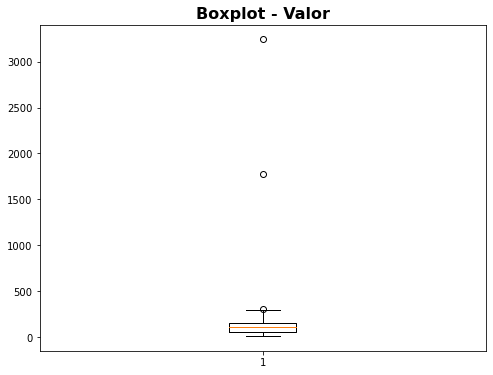

In [118]:
# gráfico boxplot para identificação de outliers de forma visual
plt.figure(figsize=[8,6])
plt.title("Boxplot - Valor", fontsize = 16, fontweight = 'bold')
plt.boxplot(df.valor)
plt.show()

In [119]:
# A partir do boxplot acima, vemos que a variável possui valores discrepantes, acima do limite superior do boxplot.
# Vamos calcular os limites inferiores e superiores do boxplot.
# primeiramente, calculamos o intervalo interquartil

iqr = np.percentile(df.valor, 75) - np.percentile(df.valor, 25)
iqr

95.60646984366146

In [120]:
# calculamos o limite inferior
limite_inf = np.maximum(np.percentile(df.valor, 25) - 1.5 * iqr, np.min(df.valor))
limite_inf

10.859149564076176

In [121]:
# calculamos o limite superior
limite_sup = np.minimum(np.percentile(df.valor, 75) + 1.5 * iqr, np.max(df.valor))
limite_sup

296.11410270598026

In [122]:
# função que captura esses valores discrepantes, a partir das informações acima
def detecta_outlier(x, limite = 1.5):
    iqr = np.percentile(x, 75) - np.percentile(x, 25)
    limite_inf = np.maximum(np.percentile(x, 25) - limite * iqr, np.min(x))
    limite_sup = np.minimum(np.percentile(x, 75) + limite * iqr, np.max(x))
    return np.where((x < limite_inf) | (x > limite_sup), 1, 0)

In [123]:
df['outlier_valor'] = detecta_outlier(df.valor)

In [124]:
# identificando as linhas que contém os outliers
df.loc[(df.outlier_valor == 1)]

,user,rec,freq,valor,outlier_valor
187,188,7.0,11.0,299.624773,1
303,304,118.0,1.0,1779.313280,1
645,646,101.0,1.0,3241.824119,1


In [125]:
df.outlier_valor.value_counts()

0    1009
1       3
Name: outlier_valor, dtype: int64

In [126]:
# tirando as linhas que contém os outliers
df = df[df['outlier_valor'] == 0]

In [127]:
df

,user,rec,freq,valor,outlier_valor
0,1,15.0,7.0,196.881015,0
1,2,51.0,6.0,162.408892,0
2,3,80.0,5.0,180.158644,0
3,4,38.0,4.0,156.048130,0
4,5,19.0,6.0,164.052067,0
...,...,...,...,...,...
1007,1008,50.0,6.0,116.867455,0
1008,1009,72.0,4.0,94.807854,0
1009,1010,50.0,5.0,99.187523,0
1010,1011,81.0,2.0,66.581900,0


In [128]:
# retirar a coluna
df.drop(['outlier_valor'], axis=1, inplace=True)

C:\Users\Biavatti\AppData\Local\Temp\ipykernel_19228\787534886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['outlier_valor'], axis=1, inplace=True)


In [129]:
df

,user,rec,freq,valor
0,1,15.0,7.0,196.881015
1,2,51.0,6.0,162.408892
2,3,80.0,5.0,180.158644
3,4,38.0,4.0,156.048130
4,5,19.0,6.0,164.052067
...,...,...,...,...
1007,1008,50.0,6.0,116.867455
1008,1009,72.0,4.0,94.807854
1009,1010,50.0,5.0,99.187523
1010,1011,81.0,2.0,66.581900


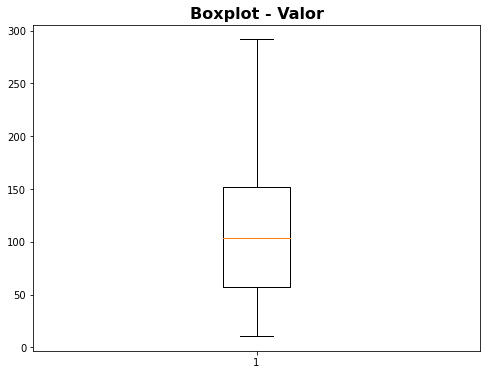

In [130]:
# gráfico boxplot para identificação de outliers de forma visual
plt.figure(figsize=[8,6])
plt.title("Boxplot - Valor", fontsize = 16, fontweight = 'bold')
plt.boxplot(df.valor)
plt.show()

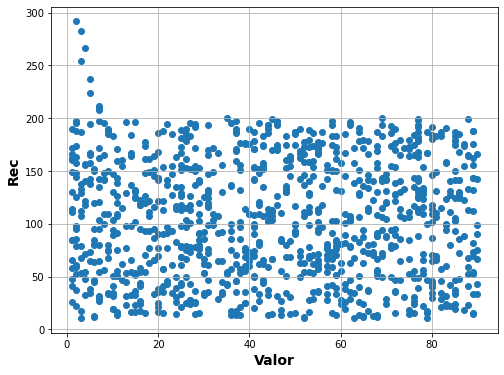

In [132]:
plt.figure(figsize=[8,6])
plt.scatter(df.rec, df.valor)
plt.xlabel('Valor', fontsize = 14 , fontweight = 'bold')
plt.ylabel('Rec', fontsize= 14 , fontweight = 'bold')
plt.grid()
plt.show()

In [138]:
st = StandardScaler()
Xsc = st.fit_transform(df.values[:, 1:])

In [139]:
Xsc

array([[-1.13920843,  1.02587518,  1.65372823],
       [ 0.2290169 ,  0.61133451,  1.035825  ],
       [ 1.33119842,  0.19679384,  1.35398437],
       ...,
       [ 0.19101064,  0.19679384, -0.09740052],
       [ 1.36920468, -1.04682818, -0.68184728],
       [-0.53110828, -1.04682818,  0.4403705 ]])

In [140]:
df.corr()

,user,rec,freq,valor
user,1.000000,0.002444,0.001925,-0.046637
rec,0.002444,1.000000,-0.008422,0.007611
freq,0.001925,-0.008422,1.000000,-0.023556
valor,-0.046637,0.007611,-0.023556,1.000000


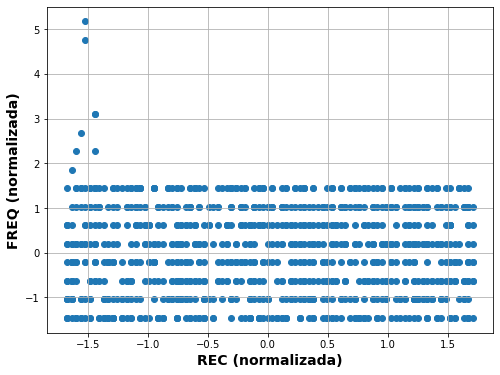

In [143]:
# REC x FREQ
plt.figure(figsize=[8,6])
plt.scatter(Xsc[:,0], Xsc[:, 1])
plt.xlabel("REC (normalizada)", fontsize = 14, fontweight = 'bold')
plt.ylabel("FREQ (normalizada)", fontsize = 14, fontweight = 'bold')
plt.grid()
plt.show()

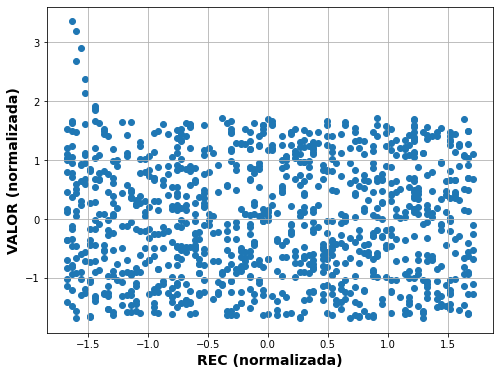

In [144]:
# REC x VALOR
plt.figure(figsize=[8,6])
plt.scatter(Xsc[:,0], Xsc[:, 2])
plt.xlabel("REC (normalizada)", fontsize = 14, fontweight = 'bold')
plt.ylabel("VALOR (normalizada)", fontsize = 14, fontweight = 'bold')
plt.grid()
plt.show()

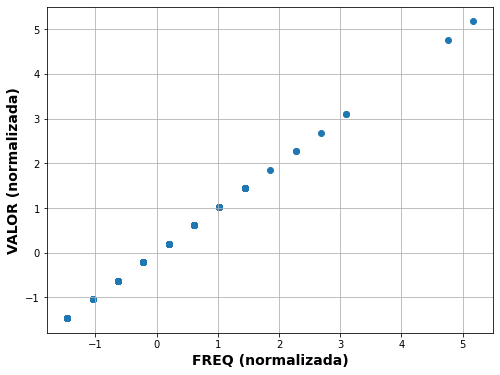

In [145]:
# FREQ x VALOR
plt.figure(figsize=[8,6])
plt.scatter(Xsc[:,1], Xsc[:, 1])
plt.xlabel("FREQ (normalizada)", fontsize = 14, fontweight = 'bold')
plt.ylabel("VALOR (normalizada)", fontsize = 14, fontweight = 'bold')
plt.grid()
plt.show()

Como não temos uma ideia inicial pré-estabelecida da quantidade de clusters, vamos utilizar a heurística da Curva de Elbow para essa escolha:

C:\Users\Biavatti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


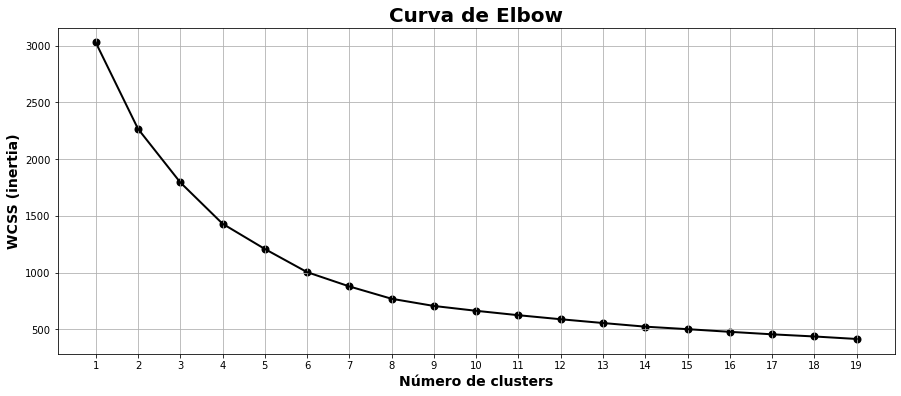

In [148]:
lista= []
for k in range(1,20):
    km=KMeans(n_clusters= k)
    km.fit(Xsc)
    lista.append(km.inertia_)
    
plt.figure(figsize=[15,6])
plt.title("Curva de Elbow", fontsize = 20, fontweight = 'bold')
plt.xlabel("Número de clusters", fontsize = 14, fontweight = 'bold')
plt.ylabel("WCSS (inertia)", fontsize = 14, fontweight = 'bold')
plt.plot(range(1, 1+len(lista)), lista, c = 'black', lw = 2)
plt.scatter(range(1, 1+len(lista)), lista, c = 'black', lw = 2)
plt.xticks(range(1,1+len(lista)))
plt.grid()
plt.show()

#### Conclusão:
A curva aponta como melhor opção entre 4 e 8 clusters

C:\Users\Biavatti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


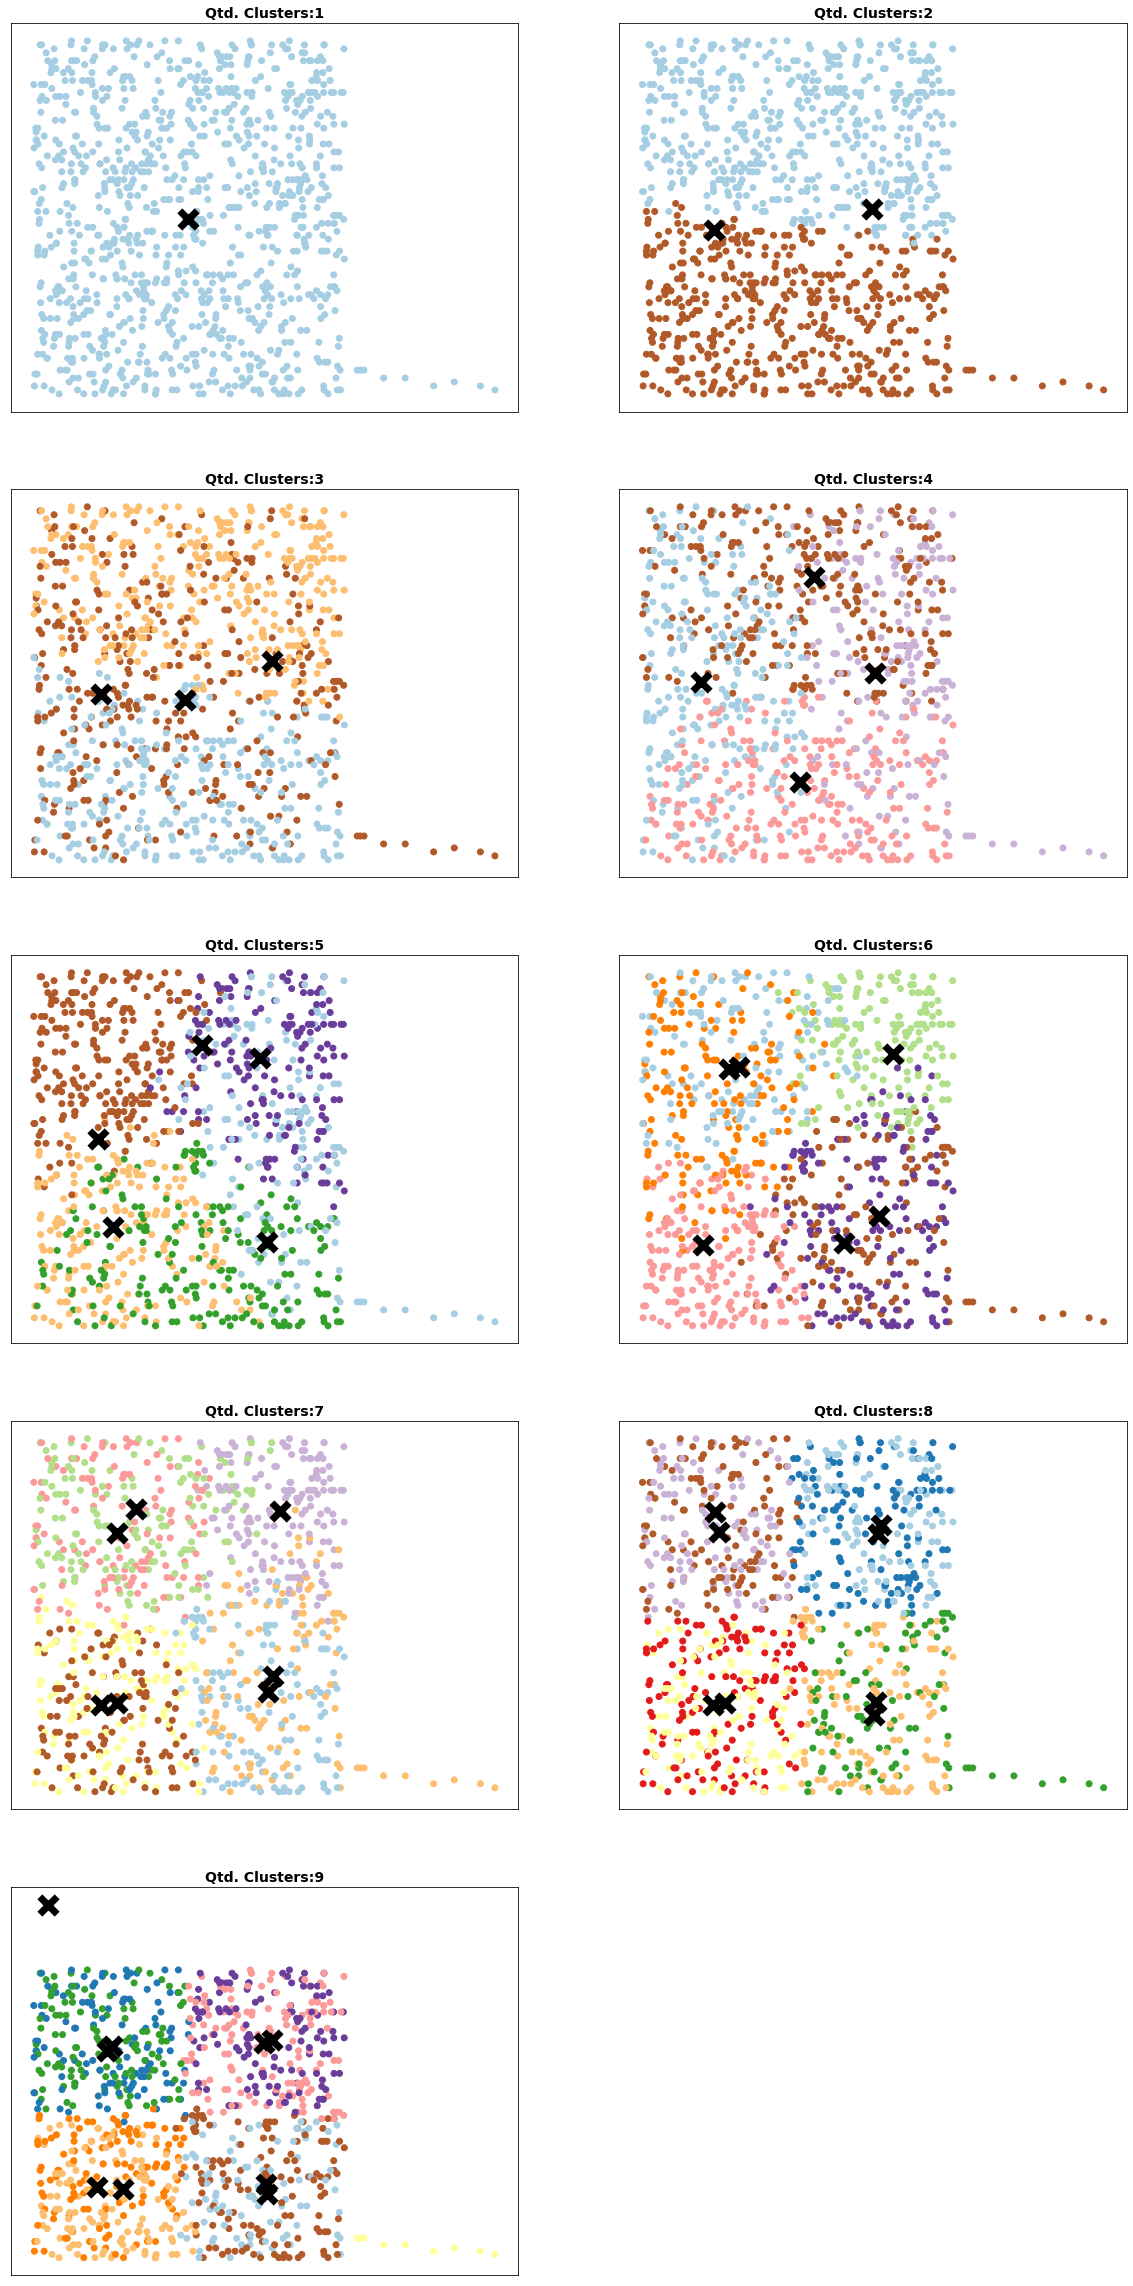

In [168]:
plt.figure(figsize=[20,50])

for k in range(1, 10):
    km = KMeans(n_clusters=k)
    km.fit(Xsc)
    plt.subplot(6,2,k)
    plt.title("Qtd. Clusters:" + str(k), fontsize = 14, fontweight = 'bold')
    plt.scatter(Xsc[:, 2], Xsc[:, 0], c = km.predict(Xsc), cmap = plt.cm.Paired)
    for centr in km.cluster_centers_:
        plt.scatter(centr[0], centr[2], s = 300, marker = 'x', c = 'black', lw = 7)
    plt.xticks([])
    plt.yticks([])
plt.show()